# ***PCA***

In [192]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd

heart_disease = fetch_ucirepo(id=45) 

X = heart_disease.data.features
y = heart_disease.data.targets 
df = pd.concat([X, y], axis=1)
df = df.dropna()
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [194]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_features = X.shape[1]         
n_components = n_features // 2

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

X_pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(n_components)])

pca_dataset = pd.concat([X_pca_df, y.reset_index(drop=True)], axis=1)

pca_dataset.to_csv("heart_disease_pca.csv", index=False)

In [196]:
y_binary = y.copy()
y_binary = (y_binary > 0).astype(int)

pca_binary = pd.concat([X_pca_df, y_binary.reset_index(drop=True)], axis=1)
pca_binary.to_csv("heart_disease_pca_binary.csv", index=False)

# ***Binary Classification Problem***

In [199]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_pca_df, y_binary, test_size=0.1, random_state=43, stratify=y_binary
)

train_df = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)

test_df = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

train_df.to_csv("train_binary_pca.csv", index=False)
test_df.to_csv("test_binary_pca.csv", index=False)

### ***Model 1: KNN***

In [202]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

k_values = [3, 4, 5, 6, 7, 8, 9, 10]
cv_scores = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv = 5, # we are using 5-folds
        scoring="accuracy"
    )
    cv_scores.append(scores.mean())
    print(f"number of neighbors={k}, CV accuracy={scores.mean():.4f}")

number of neighbors=3, CV accuracy=0.8019
number of neighbors=4, CV accuracy=0.7907
number of neighbors=5, CV accuracy=0.8094
number of neighbors=6, CV accuracy=0.8206
number of neighbors=7, CV accuracy=0.8205
number of neighbors=8, CV accuracy=0.8131
number of neighbors=9, CV accuracy=0.8056
number of neighbors=10, CV accuracy=0.8242


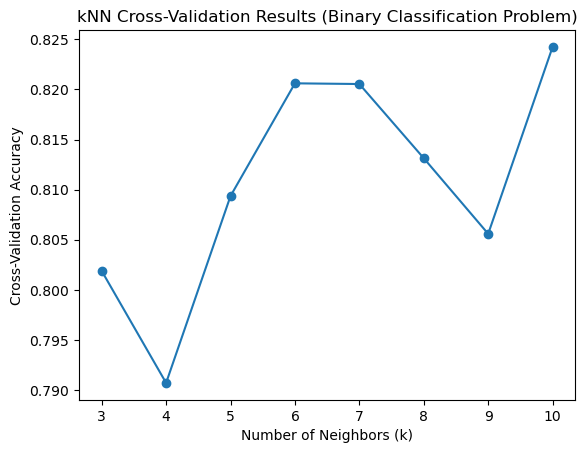

In [204]:
import matplotlib.pyplot as plt

plt.plot(k_values, cv_scores, marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Cross-Validation Accuracy")
plt.title("kNN Cross-Validation Results (Binary Classification Problem)")
plt.show()

In [206]:
best_k = k_values[np.argmax(cv_scores)]
best_knn = KNeighborsClassifier(n_neighbors=best_k)

best_knn.fit(X_train, y_train)
best_k

10

In [248]:
from sklearn.metrics import accuracy_score
import time

start_train = time.time()
best_knn.fit(X_train, y_train)
end_train = time.time()

start_pred = time.time()
y_pred = best_knn.predict(X_test)
end_pred = time.time()

print("Training time (s):", end_train - start_train)
print("Prediction time (s):", end_pred - start_pred)

acc = accuracy_score(y_test, y_pred)

print("Best k value:", best_k)
print("Test (Validation set) accuracy of the KNN model with k =", best_k, ":", acc)

y_pred_train = best_knn.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print("Train accuracy of the KNN model with k =", best_k, ":", acc_train)

Training time (s): 0.0023491382598876953
Prediction time (s): 0.006495952606201172
Best k value: 10
Test (Validation set) accuracy of the KNN model with k = 10 : 0.7666666666666667
Train accuracy of the KNN model with k = 10 : 0.850187265917603


### ***Model 2: ANN***

In [211]:
hidden_sizes = [5, 10, 20, 30, 50]

In [213]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

cv_scores_ann = []

for h in hidden_sizes:
    ann_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(
            hidden_layer_sizes=(h,),
            max_iter=1000,
            random_state=42
        ))
    ])
    
    scores = cross_val_score(
        ann_pipeline,
        X_train,
        y_train,
        cv=5,  # we are using 5-folds
        scoring="accuracy"
    )
    cv_scores_ann.append(scores.mean())
    print(f"hidden_layer_sizes=({h},), CV accuracy={scores.mean():.4f}")

hidden_layer_sizes=(5,), CV accuracy=0.8093
hidden_layer_sizes=(10,), CV accuracy=0.8393
hidden_layer_sizes=(20,), CV accuracy=0.8132
hidden_layer_sizes=(30,), CV accuracy=0.8169
hidden_layer_sizes=(50,), CV accuracy=0.7983


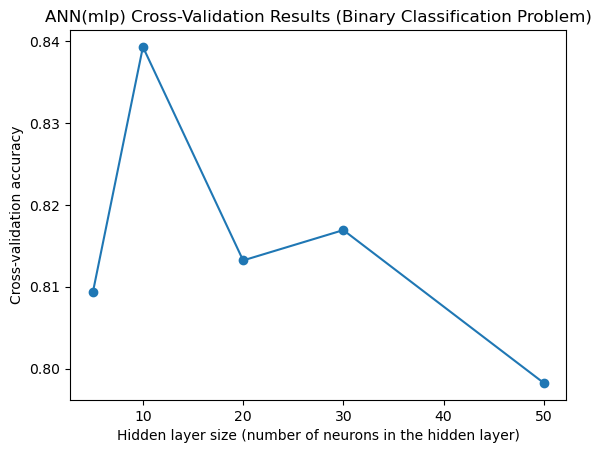

In [215]:
plt.plot(hidden_sizes, cv_scores_ann, marker='o')
plt.xlabel("Hidden layer size (number of neurons in the hidden layer)")
plt.ylabel("Cross-validation accuracy")
plt.title("ANN(mlp) Cross-Validation Results (Binary Classification Problem)")
plt.show()

In [217]:
best_h = hidden_sizes[np.argmax(cv_scores_ann)]
print("Best hidden size:", best_h)

best_ann = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(best_h,),
        max_iter=1000,
        random_state=42
    ))
])
best_h

Best hidden size: 10


10

In [254]:
start_train = time.time()
best_ann.fit(X_train, y_train)
end_train = time.time()

start_pred = time.time()
y_pred = best_ann.predict(X_test)
end_pred = time.time()

print("Training time (s):", end_train - start_train)
print("Prediction time (s):", end_pred - start_pred)

acc = accuracy_score(y_test, y_pred)

print("Best hideen layer size:", best_h)
print("Test (Validation set) accuracy of the ANN model with hideen layer size =", best_h, ":", acc)

y_pred_train = best_ann.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print("Train accuracy of the ANN model with hidden layer size =", best_h, ":", acc_train)

Training time (s): 0.12117409706115723
Prediction time (s): 0.0005021095275878906
Best hideen layer size: 10
Test (Validation set) accuracy of the ANN model with hideen layer size = 10 : 0.8
Train accuracy of the ANN model with hidden layer size = 10 : 0.8651685393258427


### ***Model 3: Decision Tree***

In [222]:
depth_values = [2, 3, 4, 5, 6]

In [224]:
from sklearn.tree import DecisionTreeClassifier
cv_scores_dt = []

for d in depth_values:
    dt = DecisionTreeClassifier(
        max_depth=d,
        random_state=43
    )
    
    scores = cross_val_score(
        dt,
        X_train,
        y_train,
        cv=5, # again, we are still using 5-folds
        scoring="accuracy"
    )
    
    cv_scores_dt.append(scores.mean())
    print(f"max_depth={d}, CV accuracy={scores.mean():.4f}")

max_depth=2, CV accuracy=0.8092
max_depth=3, CV accuracy=0.7905
max_depth=4, CV accuracy=0.7792
max_depth=5, CV accuracy=0.7529
max_depth=6, CV accuracy=0.7452


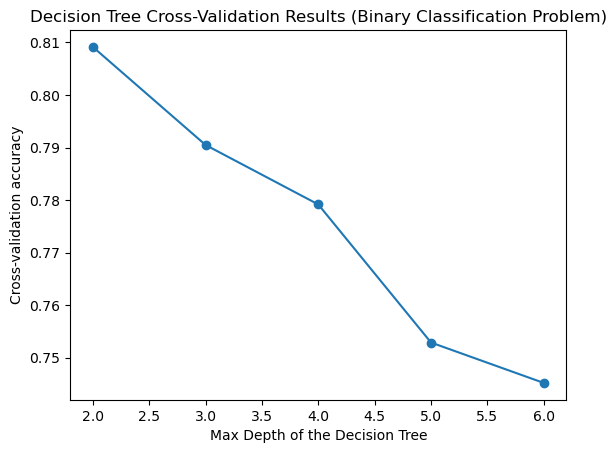

In [226]:
plt.plot(depth_values, cv_scores_dt, marker='o')
plt.xlabel("Max Depth of the Decision Tree")
plt.ylabel("Cross-validation accuracy")
plt.title("Decision Tree Cross-Validation Results (Binary Classification Problem)")
plt.show()

In [228]:
best_depth = depth_values[np.argmax(cv_scores_dt)]
print("Best max_depth:", best_depth)

best_dt = DecisionTreeClassifier(
    max_depth=best_depth,
    random_state=43
)
best_depth

Best max_depth: 2


2

In [256]:
start_train = time.time()
best_dt.fit(X_train, y_train)
end_train = time.time()

start_pred = time.time()
y_pred = best_dt.predict(X_test)
end_pred = time.time()

print("Training time (s):", end_train - start_train)
print("Prediction time (s):", end_pred - start_pred)

acc = accuracy_score(y_test, y_pred)

print("Best depth value:", best_depth)
print("Test (Validation set) accuracy of the decision tree with a depth =", best_depth, ":", acc)

y_pred_train = best_dt.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print("Train accuracy of the decision tree with a depth =", best_depth, ":", acc_train)

Training time (s): 0.0038411617279052734
Prediction time (s): 0.0011258125305175781
Best depth value: 2
Test (Validation set) accuracy of the decision tree with a depth = 2 : 0.7333333333333333
Train accuracy of the decision tree with a depth = 2 : 0.8314606741573034


### ***Model 4: Random Forest***

In [233]:
n_estimators_list = [50, 100, 150, 200, 300]

In [235]:
from sklearn.ensemble import RandomForestClassifier
cv_scores_rf = []

for n in n_estimators_list:
    rf = RandomForestClassifier(
        n_estimators=n,
        random_state=43,
    )
    
    scores = cross_val_score(
        rf,
        X_train,
        y_train,
        cv=5,
        scoring="accuracy"
    )
    
    cv_scores_rf.append(scores.mean())
    print(f"n_estimators={n}, CV accuracy={scores.mean():.4f}")


n_estimators=50, CV accuracy=0.7944
n_estimators=100, CV accuracy=0.8055
n_estimators=150, CV accuracy=0.7981
n_estimators=200, CV accuracy=0.8018
n_estimators=300, CV accuracy=0.8056


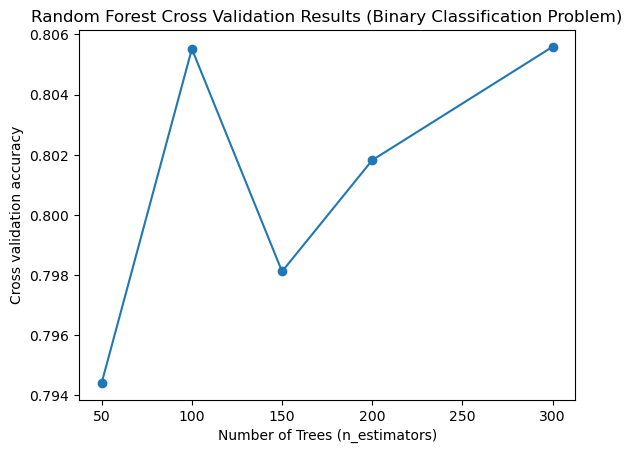

In [237]:
plt.plot(n_estimators_list, cv_scores_rf, marker='o')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Cross validation accuracy")
plt.title("Random Forest Cross Validation Results (Binary Classification Problem)")
plt.show()

In [239]:
best_n = n_estimators_list[np.argmax(cv_scores_rf)]

best_rf = RandomForestClassifier(
    n_estimators=best_n,
    random_state=43,
)

best_n

300

In [258]:
start_train = time.time()
best_rf.fit(X_train, y_train)
end_train = time.time()

start_pred = time.time()
y_pred = best_rf.predict(X_test)
end_pred = time.time()

print("Training time (s):", end_train - start_train)
print("Prediction time (s):", end_pred - start_pred)

acc = accuracy_score(y_test, y_pred)

print("Best number of decision trees value:", best_n)
print("Test (Validation set) accuracy of the random forest with number of decision trees inside =", best_n, ":", acc)

y_pred_train = best_rf.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print("Train accuracy of the random forest with number of decision trees inside = ", best_n, ":", acc_train)

Training time (s): 0.15674710273742676
Prediction time (s): 0.0033872127532958984
Best k value: 300
Test (Validation set) accuracy of the random forest with number of decision trees inside = 300 : 0.7666666666666667
Train accuracy of the random forest with number of decision trees inside =  300 : 1.0


# ***Multi Classification Problem***

In [260]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_pca_df, y, test_size=0.1, random_state=43, stratify=y
)

train_df = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)

test_df = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

train_df.to_csv("train_multi_pca.csv", index=False)
test_df.to_csv("test_multi_pca.csv", index=False)

### ***Model 1: KNN***

In [263]:
k_values = [3, 4, 5, 6, 7, 8, 9, 10]
cv_scores = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv = 5, # we are using 5-folds
        scoring="accuracy"
    )
    cv_scores.append(scores.mean())
    print(f"number of neighbors={k}, CV accuracy={scores.mean():.4f}")

number of neighbors=3, CV accuracy=0.5542
number of neighbors=4, CV accuracy=0.5656
number of neighbors=5, CV accuracy=0.5620
number of neighbors=6, CV accuracy=0.5844
number of neighbors=7, CV accuracy=0.6068
number of neighbors=8, CV accuracy=0.5843
number of neighbors=9, CV accuracy=0.5806
number of neighbors=10, CV accuracy=0.5993


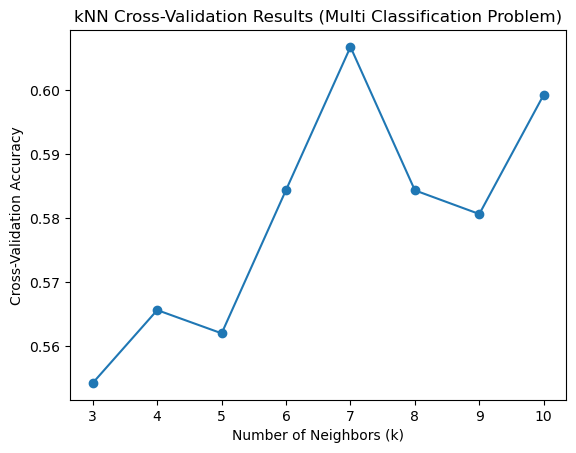

In [304]:
import matplotlib.pyplot as plt

plt.plot(k_values, cv_scores, marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Cross-Validation Accuracy")
plt.title("kNN Cross-Validation Results (Multi Classification Problem)")
plt.show()

In [267]:
best_k = k_values[np.argmax(cv_scores)]
best_knn = KNeighborsClassifier(n_neighbors=best_k)

best_knn.fit(X_train, y_train)
best_k

7

In [269]:
from sklearn.metrics import accuracy_score
import time

start_train = time.time()
best_knn.fit(X_train, y_train)
end_train = time.time()

start_pred = time.time()
y_pred = best_knn.predict(X_test)
end_pred = time.time()

print("Training time (s):", end_train - start_train)
print("Prediction time (s):", end_pred - start_pred)

acc = accuracy_score(y_test, y_pred)

print("Best k value:", best_k)
print("Test (Validation set) accuracy of the KNN model with k =", best_k, ":", acc)

y_pred_train = best_knn.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print("Train accuracy of the KNN model with k =", best_k, ":", acc_train)

Training time (s): 0.0025742053985595703
Prediction time (s): 0.00551605224609375
Best k value: 7
Test (Validation set) accuracy of the KNN model with k = 7 : 0.6
Train accuracy of the KNN model with k = 7 : 0.6666666666666666


### ***Model 2: ANN***

In [272]:
hidden_sizes = [5, 10, 20, 30, 50]

In [274]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

cv_scores_ann = []

for h in hidden_sizes:
    ann_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(
            hidden_layer_sizes=(h,),
            max_iter=10000,
            random_state=42
        ))
    ])
    
    scores = cross_val_score(
        ann_pipeline,
        X_train,
        y_train,
        cv=5,  # we are using 5-folds
        scoring="accuracy"
    )
    cv_scores_ann.append(scores.mean())
    print(f"hidden layer sizes=({h},), CV accuracy={scores.mean():.4f}")

hidden layer sizes=(5,), CV accuracy=0.6068
hidden layer sizes=(10,), CV accuracy=0.5579
hidden layer sizes=(20,), CV accuracy=0.5883
hidden layer sizes=(30,), CV accuracy=0.5542
hidden layer sizes=(50,), CV accuracy=0.5546


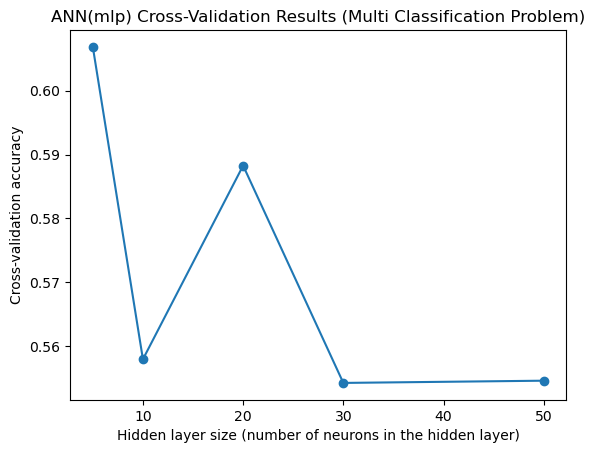

In [306]:
plt.plot(hidden_sizes, cv_scores_ann, marker='o')
plt.xlabel("Hidden layer size (number of neurons in the hidden layer)")
plt.ylabel("Cross-validation accuracy")
plt.title("ANN(mlp) Cross-Validation Results (Multi Classification Problem)")
plt.show()

In [276]:
best_h = hidden_sizes[np.argmax(cv_scores_ann)]
print("Best hidden size:", best_h)

best_ann = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(best_h,),
        max_iter=1000,
        random_state=42
    ))
])
best_h

Best hidden size: 5


5

In [280]:
start_train = time.time()
best_ann.fit(X_train, y_train)
end_train = time.time()

start_pred = time.time()
y_pred = best_ann.predict(X_test)
end_pred = time.time()

print("Training time (s):", end_train - start_train)
print("Prediction time (s):", end_pred - start_pred)

acc = accuracy_score(y_test, y_pred)

print("Best hideen layer size:", best_h)
print("Test (Validation set) accuracy of the ANN model with hideen layer size =", best_h, ":", acc)

y_pred_train = best_ann.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print("Train accuracy of the ANN model with hidden layer size =", best_h, ":", acc_train)

Training time (s): 0.15110492706298828
Prediction time (s): 0.0004532337188720703
Best hideen layer size: 5
Test (Validation set) accuracy of the ANN model with hideen layer size = 5 : 0.6333333333333333
Train accuracy of the ANN model with hidden layer size = 5 : 0.6741573033707865


### ***Model 3: Decision Tree***

In [283]:
depth_values = [2, 3, 4, 5, 6]

In [285]:
from sklearn.tree import DecisionTreeClassifier
cv_scores_dt = []

for d in depth_values:
    dt = DecisionTreeClassifier(
        max_depth=d,
        random_state=43
    )
    
    scores = cross_val_score(
        dt,
        X_train,
        y_train,
        cv=5, # again, we are still using 5-folds
        scoring="accuracy"
    )
    
    cv_scores_dt.append(scores.mean())
    print(f"max depth={d}, CV accuracy={scores.mean():.4f}")

max depth=2, CV accuracy=0.6142
max depth=3, CV accuracy=0.5620
max depth=4, CV accuracy=0.5584
max depth=5, CV accuracy=0.5244
max depth=6, CV accuracy=0.5358


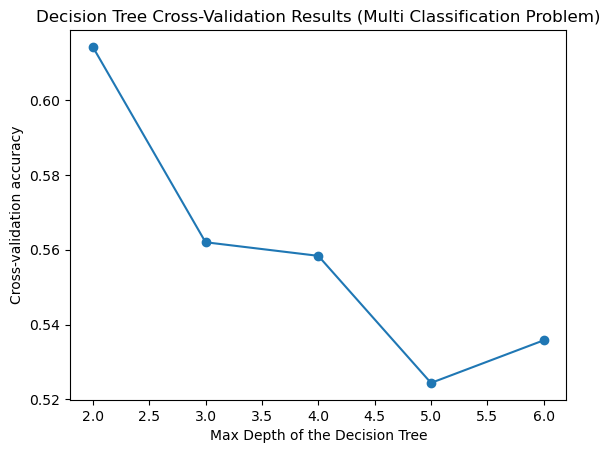

In [308]:
plt.plot(depth_values, cv_scores_dt, marker='o')
plt.xlabel("Max Depth of the Decision Tree")
plt.ylabel("Cross-validation accuracy")
plt.title("Decision Tree Cross-Validation Results (Multi Classification Problem)")
plt.show()

In [289]:
best_depth = depth_values[np.argmax(cv_scores_dt)]
print("Best max_depth:", best_depth)

best_dt = DecisionTreeClassifier(
    max_depth=best_depth,
    random_state=43
)
best_depth

Best max_depth: 2


2

In [291]:
start_train = time.time()
best_dt.fit(X_train, y_train)
end_train = time.time()

start_pred = time.time()
y_pred = best_dt.predict(X_test)
end_pred = time.time()

print("Training time (s):", end_train - start_train)
print("Prediction time (s):", end_pred - start_pred)

acc = accuracy_score(y_test, y_pred)

print("Best depth value:", best_depth)
print("Test (Validation set) accuracy of the decision tree with a depth =", best_depth, ":", acc)

y_pred_train = best_dt.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print("Train accuracy of the decision tree with depth =", best_depth, ":", acc_train)

Training time (s): 0.003767728805541992
Prediction time (s): 0.0007219314575195312
Best depth value: 2
Test (Validation set) accuracy of the decision tree with a depth = 2 : 0.6
Train accuracy of the decision tree with depth = 2 : 0.6292134831460674


### ***Model 4: Random Forest***

In [294]:
n_estimators_list = [50, 100, 150, 200, 300]

In [296]:
from sklearn.ensemble import RandomForestClassifier
cv_scores_rf = []

for n in n_estimators_list:
    rf = RandomForestClassifier(
        n_estimators=n,
        random_state=43,
    )
    
    scores = cross_val_score(
        rf,
        X_train,
        y_train,
        cv=5,
        scoring="accuracy"
    )
    
    cv_scores_rf.append(scores.mean())
    print(f"number of estimators={n}, CV accuracy={scores.mean():.4f}")


number of estimators=50, CV accuracy=0.5581
number of estimators=100, CV accuracy=0.5693
number of estimators=150, CV accuracy=0.5657
number of estimators=200, CV accuracy=0.5582
number of estimators=300, CV accuracy=0.5620


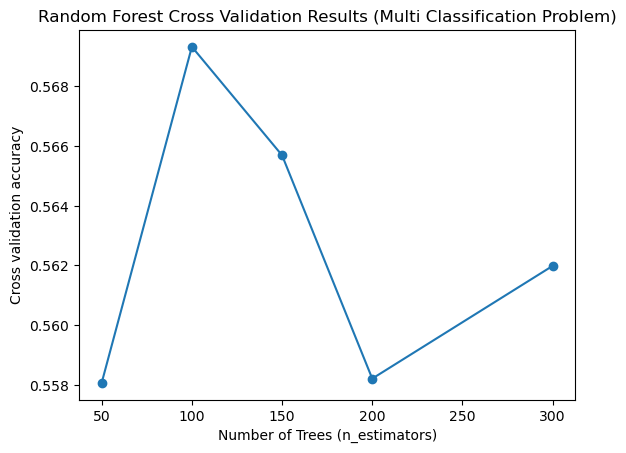

In [310]:
plt.plot(n_estimators_list, cv_scores_rf, marker='o')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Cross validation accuracy")
plt.title("Random Forest Cross Validation Results (Multi Classification Problem)")
plt.show()

In [300]:
best_n = n_estimators_list[np.argmax(cv_scores_rf)]

best_rf = RandomForestClassifier(
    n_estimators=best_n,
    random_state=43,
)

best_n

100

In [302]:
start_train = time.time()
best_rf.fit(X_train, y_train)
end_train = time.time()

start_pred = time.time()
y_pred = best_rf.predict(X_test)
end_pred = time.time()

print("Training time (s):", end_train - start_train)
print("Prediction time (s):", end_pred - start_pred)

acc = accuracy_score(y_test, y_pred)

print("Best number of decision trees value:", best_n)
print("Test (Validation set) accuracy of the random forest with number of decision trees inside =", best_n, ":", acc)

y_pred_train = best_rf.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print("Train accuracy of the random forest with number of decision trees =", best_n, ":", acc_train)

Training time (s): 0.08267498016357422
Prediction time (s): 0.0016798973083496094
Best number of decision trees value: 100
Test (Validation set) accuracy of the random forest with number of decision trees inside = 100 : 0.6
Train accuracy of the random forest with number of decision trees = 100 : 1.0
